# Hedonic vs Utilitarian classification

pip install missingpy

## First: import necessary libraries and find file names

In [1]:
import numpy as np
import pandas as pd
import json 
from os import walk

from missingpy import MissForest

from sklearn.manifold import Isomap, TSNE, MDS, LocallyLinearEmbedding
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report

mypath='./reviews_features'
_, _, filenames = next(walk(mypath))
print(filenames)

['health.json', 'sports.json', 'groceries.json', 'pet.json', 'instruments.json', 'digital_music.json', 'movies.json', 'home.json', 'baby.json', 'tools.json', 'clothing.json', 'video.json', 'garden.json', 'toys.json', 'cds_vinyl.json', 'beauty.json', 'office.json', 'electronics.json', 'kindle.json', 'automotive.json', 'apps_android.json', 'books.json', 'games.json', 'mobile.json']


/home/pedro/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Lets import our data

In [2]:
df = pd.DataFrame(
    columns=['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText','overall', 'summary', 'unixReviewTime', 'reviewTime', 'features','amazonCategory'],
)
for name in filenames:  
    temp = pd.read_json(mypath+'/'+name , lines =True)
    temp['amazonCategory'] = name[:-5]
    df = df.append( temp ,ignore_index=True)

**Note that we have stored the category itself in amazonCategory column**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232748 entries, 0 to 232747
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviewerID      232748 non-null  object
 1   asin            232748 non-null  object
 2   reviewerName    230910 non-null  object
 3   helpful         232748 non-null  object
 4   reviewText      232748 non-null  object
 5   overall         232748 non-null  object
 6   summary         232748 non-null  object
 7   unixReviewTime  232748 non-null  object
 8   reviewTime      232748 non-null  object
 9   features        232748 non-null  object
 10  amazonCategory  232748 non-null  object
dtypes: object(11)
memory usage: 19.5+ MB


**We don't have any problem reggarding nulls on our features**

In [4]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,features,amazonCategory
0,A1JUPR7LPMYG1X,B00009V2QX,"Chef Kim ""My Review""","[0, 0]",Its time for me to purchase another box. great...,4,Great,1356739200,"12 29, 2012","[-0.098792488888888, 0.24677984888888901, 0.37...",health
1,A6YT8ATZ4SEKT,B00009V2QX,C. Moran,"[0, 0]","Recieved OLD black and silver procell package,...",3,recieved OLD STOCK,1401840000,"06 4, 2014","[-0.07366211999999901, 0.345128, 0.30181372, -...",health
2,A0678500JUN3N7KUG4PS,B000056OWW,GigiS,"[0, 0]",The best cold sore remover product I've ever u...,5,Great product.,1403049600,"06 18, 2014","[-0.23953764705882302, 0.21731229411764702, 0....",health
3,A4DRGD09QEE9I,B00009V2QX,"C. R. Dyer ""home maker""","[0, 0]",If you've ever noticed your flashlights are di...,5,Batteries,1357516800,"01 7, 2013","[-0.22847052941176402, 0.270014588235294, 0.45...",health
4,ABT4HGNR22RWO,B00009V2QX,Daniel L. Kellett Sr.,"[0, 0]",Received fast and as described. I have only u...,5,Big bang for your buck...,1320105600,"11 1, 2011","[-0.17499656521739101, 0.29650973913043405, 0....",health


In [5]:
print(pd.unique(df.amazonCategory), len(pd.unique(df.amazonCategory)))

['health' 'sports' 'groceries' 'pet' 'instruments' 'digital_music'
 'movies' 'home' 'baby' 'tools' 'clothing' 'video' 'garden' 'toys'
 'cds_vinyl' 'beauty' 'office' 'electronics' 'kindle' 'automotive'
 'apps_android' 'books' 'games' 'mobile'] 24


**All the categories are correctly imported**

## Data visualizations: just an overview

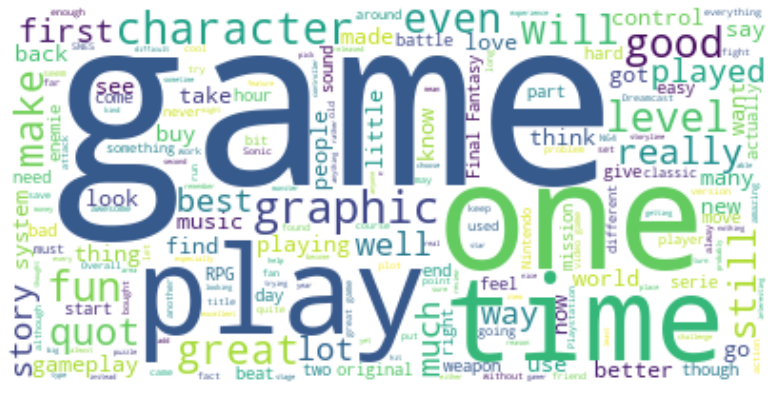

In [6]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,7)

text = " ".join(review for review in df.loc[df.amazonCategory=='games'].reviewText)
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

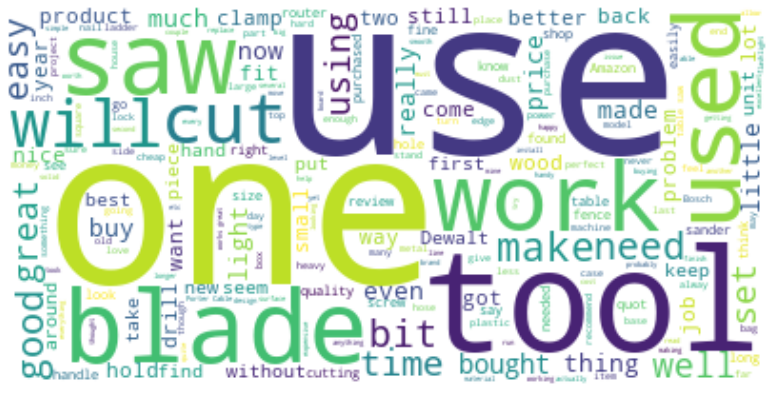

In [7]:
text = " ".join(review for review in df.loc[df.amazonCategory=='tools'].reviewText)
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

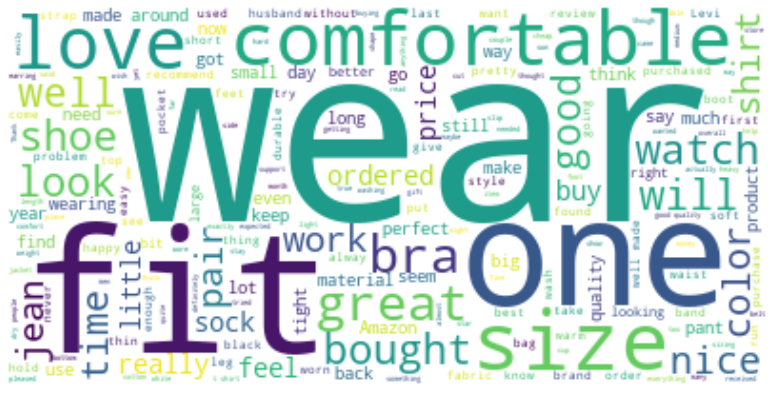

In [8]:
text = " ".join(review for review in df.loc[df.amazonCategory=='clothing'].reviewText)
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [9]:
df.loc[df.amazonCategory=='games']['reviewText'][212119]

"Back in 1993, a little game called Myst appeared. Everyone went crazy for  it -- it featured amazing graphics, addicting search and explore gameplay,  and it was actually educational. A main part of the game was reading, so it  figures that many parents were so supportive of it. It was also, though,  terribly spooky at times. You could be anywhere in the world of Myst and  still feel a general sense of... well, spookiness.But Myst was in 1993  -- and even though it held well throughout several years (which is  amazingly good), it started to be noticed more as a classic than current  technology.So how well can &quot;Riven: The Sequel To Myst&quot; hold up  against &quot;current technology&quot; and the original classic? By simply  making the adventure more intresting, more long, and with more  &quot;spookiness&quot; -- an original Myst-cliche that adds drama to the  game.&quot;Riven&quot; is even more rewarding than &quot;Myst&quot; so  much to the fact that it is sometimes speechless.

## Impute the categories we already know
### Paper

- Here we have an important note: 

    -> Q1 (quadrand 1) = utilitarian and not hedonic
    
    -> Q2 (quadrand 2) = utilitarian and hedonic
    
    -> Q3 (quadrand 3) = not utilitarian and not hedonic
    
    -> Q4 (quadrand 4) = not utilitarian and hedonic
    
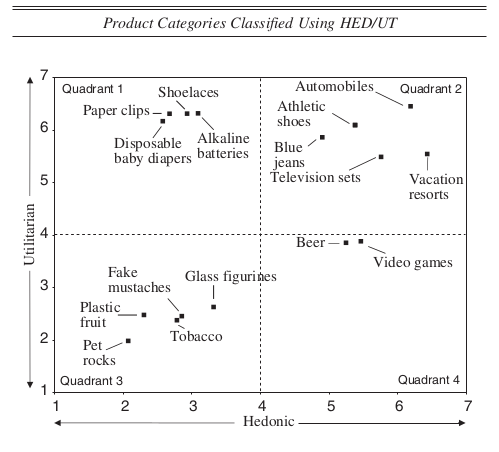

**Note that automobile and video games (Amazon) can be directly inputted in Q2 and Q4 respectively (paper)**

  Here we can identify other possible combinations like inside sports on amazon we will probably find athletic shoes and shoelaces, or inside of home we probably find television sets and glass figurines
  
  But we will have to take a look into each product's name to match them

### Import paper classes

In [10]:
paper_table = pd.read_csv('JMR_paper_table.csv')
paper_table

,name,category
0,shoelaces,Q1
1,paper clips,Q1
2,disposable baby diapers,Q1
3,alkaline batteries,Q1
4,automobiles,Q2
5,athletic shoes,Q2
6,blue jeans,Q2
7,television sets,Q2
8,vacation resorts,Q2
9,glass figurines,Q3


### Inputting nans on our dataset as target label

In [11]:
df['class'] = np.nan

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232748 entries, 0 to 232747
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      232748 non-null  object 
 1   asin            232748 non-null  object 
 2   reviewerName    230910 non-null  object 
 3   helpful         232748 non-null  object 
 4   reviewText      232748 non-null  object 
 5   overall         232748 non-null  object 
 6   summary         232748 non-null  object 
 7   unixReviewTime  232748 non-null  object 
 8   reviewTime      232748 non-null  object 
 9   features        232748 non-null  object 
 10  amazonCategory  232748 non-null  object 
 11  class           0 non-null       float64
dtypes: float64(1), object(11)
memory usage: 21.3+ MB


### Metadata import 
We found a problem here: the product's name is in the metadata and not with the reviews

Inside of metadata title there's the product's name. We will have to face a large problem to join the meta data into the dataset itself

In [13]:
metaPath='./metadata'
_, _, files = next(walk(metaPath))
print(files)

['meta_Patio_Lawn_and_Garden.json', 'meta_Arts_Crafts_and_Sewing.json', 'meta_CDs_and_Vinyl.json', 'meta_Prime_Pantry.json', 'meta_Toys_and_Games.json', 'meta_Industrial_and_Scientific.json', 'meta_Appliances.json', 'meta_Clothing_Shoes_and_Jewelry.json', 'meta_Pet_Supplies.json', 'meta_Books.json', 'meta_Luxury_Beauty.json', 'meta_Cell_Phones_and_Accessories.json', 'meta_Grocery_and_Gourmet_Food.json', 'meta_Tools_and_Home_Improvement.json', 'meta_Sports_and_Outdoors.json', 'meta_Office_Products.json', 'meta_Software.json', 'meta_Kindle_Store.json', 'meta_Home_and_Kitchen.json', 'meta_Magazine_Subscriptions.json', 'meta_Video_Games.json', 'meta_Movies_and_TV.json', 'meta_Automotive.json', 'meta_All_Beauty.json', 'meta_Digital_Music.json', 'meta_AMAZON_FASHION.json', 'meta_Gift_Cards.json', 'meta_Electronics.json', 'meta_Musical_Instruments.json']


In [ ]:
desired_columns= ['title', 'description', 'feature', 'asin']
clone = df.reset_index()
result = pd.DataFrame()

for file in files:
    with pd.read_json(metaPath+'/'+file, lines=True, chunksize=20000) as reader:
        reader
        for chunk in reader:
            chunk = chunk[desired_columns]
            temp = clone.merge(chunk, how='inner', on='asin')
            result = pd.concat([result, temp], ignore_index=True)
            print(result.info())

result.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4517 entries, 0 to 4516
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           4517 non-null   int64  
 1   reviewerID      4517 non-null   object 
 2   asin            4517 non-null   object 
 3   reviewerName    4497 non-null   object 
 4   helpful         4517 non-null   object 
 5   reviewText      4517 non-null   object 
 6   overall         4517 non-null   object 
 7   summary         4517 non-null   object 
 8   unixReviewTime  4517 non-null   object 
 9   reviewTime      4517 non-null   object 
 10  features        4517 non-null   object 
 11  amazonCategory  4517 non-null   object 
 12  class           0 non-null      float64
 13  title           4517 non-null   object 
 14  description     4517 non-null   object 
 15  feature         4517 non-null   object 
dtypes: float64(1), int64(1), object(14)
memory usage: 564.8+ KB
None
<class 'panda

In [ ]:
meta = pd.read_json(metaPath+'/meta_All_Beauty.json', lines =True) # limit to 600mb  meta_AMAZON_FASHION.json
#meta = pd.read_json(metaPath+'/meta_AMAZON_FASHION.json', lines =True)
desired_columns= ['title', 'description', 'feature', 'asin']
meta = meta[desired_columns]
meta.head()

In [ ]:
#clone = df
#clone = clone.set_index('asin')
#result = clone.merge(meta, how='left', on='asin', suffixes=('', '_y'),indicator=True)
#result.info()

In [ ]:
#result.groupby('_merge').size()

In [ ]:
#result.loc[~(result['_merge'] == 'right_only')].info()

In [ ]:
#result.title.fillna(result.title_y, inplace=True)
#result.description.fillna(result.description_y, inplace=True)
#result.feature.fillna(result.feature_y, inplace=True)

In [ ]:
#result.info()

In [ ]:
#result.drop( columns=['title_y', 'description_y', 'feature_y'], inplace=True)

In [ ]:
result.info()

In [ ]:
len(pd.unique(result['index']))

In [ ]:
df.info()

In [ ]:
#merged = df.merge(result, how='outer', on='asin')
#merged.info()

In [ ]:
len(pd.unique(df.reset_index().merge(result,how='outer',on='index', suffixes=['','_y'])['index']))

In [ ]:
x = df.reset_index().merge(result,how='outer',on='index', suffixes=['','_y']).drop_duplicates(subset='index')

In [ ]:
x.info()

In [ ]:
columns_drop=['reviewerID_y', 'asin_y', 'reviewerName_y', 'helpful_y', 'reviewText_y',
       'overall_y', 'summary_y', 'unixReviewTime_y', 'reviewTime_y', 'features_y',
       'amazonCategory_y', 'class_y']

In [ ]:
x.drop(columns=columns_drop,inplace=True)

In [ ]:
x.info()

### Impute known paper values

In [ ]:
x.loc[x.amazonCategory=='games','class'] = 'Q4'

In [ ]:
x.loc[x.amazonCategory=='games','class']

In [ ]:
x.loc[x.amazonCategory=='automotive','class'] = 'Q2'

In [ ]:
x.loc[x.amazonCategory=='automotive','class']

In [ ]:
x.info()

In [ ]:
19854/232748 *100

In [ ]:
x.loc[~x.title.isna()]['feature']

In [ ]:
paper_table.name.values

In [ ]:
x['feature']=x['feature'].fillna('').apply(' '.join)

In [ ]:
x['description']=x['description'].fillna('').apply(' '.join)

In [ ]:
len(x.loc[x.description.str.contains('athletic') & x.description.str.contains('shoe')])

In [ ]:
x.loc[x.description.str.contains('athletic') & x.description.str.contains('shoe'),'description'].values 
# they are not athletic shoes, they are only socks for sports (not the same=> do not make sense)

In [ ]:
len(x.loc[x.title.fillna('').str.contains('TV') | x.title.fillna('').str.contains('television')])

In [ ]:
pd.unique(x.loc[x.title.fillna('').str.contains('TV') | x.title.fillna('').str.contains('television'), 'title'].values)

In [ ]:
x.loc[x.title=='Sony KV-9PT50 9&quot; Trinitron TV','class'] = 'Q2'

In [ ]:
x.loc[x.title=='Sony KV-9PT50 9&quot; Trinitron TV','class']

In [ ]:
x.loc[x.description.fillna('').str.contains('diapers'), 'description'] ### this is diapers for dogs hahahah

In [ ]:
x.loc[x.description.fillna('').str.contains('batteries') & x.description.fillna('').str.contains('alkaline'), 'title']
# does not seam to be right 

In [ ]:
x.loc[x.title.fillna('').str.contains('paper') & x.title.fillna('').str.contains('clips'), 'title'].values

In [ ]:
pd.unique(x.loc[x.description.fillna('').str.contains('paper') & x.description.fillna('').str.contains('clips'), 'title'].values)

In [ ]:
x.loc[x.title=='ACCO Binder Clips, Mini, 1 Box, 12 Clips/Box (72010)','class'] = 'Q1'
x.loc[x.title=='ACCO Binder Clips, Mini, 1 Box, 12 Clips/Box (72010)','class']

In [ ]:
x.loc[x.title=='ACCO Paper Clips, Jumbo, Smooth, Economy, 10 Boxes, 100/Box (72580)','class'] = 'Q1'
x.loc[x.title=='ACCO Paper Clips, Jumbo, Smooth, Economy, 10 Boxes, 100/Box (72580)','class']

In [ ]:
x.loc[x.title=='OfficemateOIC Mini Binder Clips, Assorted Colors, 60 Clips per Tub (31024)','class'] = 'Q1'
x.loc[x.title=='OfficemateOIC Mini Binder Clips, Assorted Colors, 60 Clips per Tub (31024)','class']

In [ ]:
x.info()

### Prepare for imputation (cleaning & droppings)

In [ ]:
19918 / 232748 *100

In [ ]:
x.features

In [ ]:
len(x.features[1])

In [ ]:
#x.to_json('data_and_meta.json')

In [ ]:
l = x.features.tolist()

In [ ]:
data = pd.DataFrame(l,columns=[i for i in range(len(x.features[1]))])
data

In [ ]:
data['class'] = x['class'].reset_index().drop(columns='index')

In [ ]:
data.head()

In [ ]:
classes = data['class']

In [ ]:
data.to_json('features_label.json')

In [ ]:
categorical = ['class']
numerical = []
X=data
X[categorical] = X[categorical].apply(lambda series: pd.Series(
    LabelEncoder().fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
))


print(data)

#imp_num = IterativeImputer(estimator=RandomForestRegressor(),
#                           initial_strategy='mean',
#                           max_iter=10, random_state=0)

imp_cat = IterativeImputer(estimator=RandomForestClassifier(), 
                           initial_strategy='mean',
                           max_iter=30, random_state=42)

#data[numerical] = imp_num.fit_transform(data[numerical])
data[categorical] = imp_cat.fit_transform(data[categorical])

print(data)

In [ ]:
data.groupby('class').size()

In [ ]:
x.groupby('class').size()

In [ ]:
#categorical = ['class']
#imputer = MissForest()
#X= pd.DataFrame(l,columns=[i for i in range(len(x.features[1]))])
#X['class'] = x['class'].reset_index().drop(columns='index')

#X[categorical] = X[categorical].apply(lambda series: pd.Series(
#    LabelEncoder().fit_transform(series[series.notnull()]),
#    index=series[series.notnull()].index
#))

#X_imputed = imputer.fit_transform(X)
#X_imputed

In [ ]:
df = pd.read_json('features_label.json')
df.info()

In [ ]:
#df.loc[~df['class'].isnull()]

In [ ]:
df['class'] = df['class'].astype('category')

In [ ]:
df.head()

In [ ]:
df.groupby('class').size()

In [ ]:
from sklearn import preprocessing
categorical = ['class']
le = preprocessing.LabelEncoder()
df[categorical] = df[categorical].apply(lambda series: pd.Series(
    le.fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
))

In [ ]:
%%time

imputer = MissForest(random_state=42, class_weight='balanced')
imputed = imputer.fit_transform(df, cat_vars=119)
imputed

In [ ]:
cat_cols=['class']
imputed = pd.DataFrame(imputed, columns=df.columns.tolist())

imputed.describe(include='all')

In [ ]:
imputed.groupby('class').size()

In [ ]:
metadata = pd.read_json('data_and_meta.json').reset_index()
metadata.info()

In [ ]:
metadata['CLASS'] = imputed['class']
metadata.loc[~metadata.title.isnull() & (metadata.CLASS == 2)].iloc[100]

In [ ]:
metadata['CLASS'] = le.inverse_transform(imputed['class'].astype(int)[imputed['class'].notnull()])

In [ ]:
metadata